## Bigrams Model in Python

This notebook implements a bigram model based on a corpus (dataset) of English first names.

A [bigram](probabilistic) is a sequence of two consecutive tokens (i.e. letters.)
Use a corpus of first names, we define a bigram model that for each bigram `XY` defines the probability of `Y` occurs in a name given `X` preceeds it.

After defining the model we explore its ability to generate new names and testing the model's performance against a validation set. 

### Sources
- This notebook is based of the [makemore pt.1](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb) tutorial provided by @karpathy on GitHub.
- The [corpus](https://github.com/aakashkag/People-Name-List/tree/master/US-People-Names) of names is provided by @aakashkag on GitHub.


## Reading inspecting the data

We being by splitting our dataset into two: a training and validation set. 
The training set is used for training the model, while the validation will only be used to compare our model against. 

In [61]:
# read training data
fp = "../.data/nlp/"
train_set = open(f'{fp}training_corpus.txt', 'r').read().splitlines()
valid_set = open(f'{fp}validation_corpus.txt', 'r').read().splitlines()

In [62]:
# Summary stats on the training set
print("Min word length: ", min(len(w) for w in train_set))
print("Average word length: ", sum(len(w) for w in train_set)/len(train_set))
print("Max word length: ", max(len(w) for w in train_set))
print("Number of names: ", len(train_set))

Min word length:  2
Average word length:  6.310535714285714
Max word length:  15
Number of names:  28000


In [63]:
# Inspect frequency of different characters
d = {}
for w in train_set:
    for char in list(w):
        # Increment count of each character
        d[char] = d.get(char, 0) + 1

In [64]:
# Sorted by character
sorted(d.items(), key = lambda kv: kv[0])

[('a', 29184),
 ('b', 2394),
 ('c', 3888),
 ('d', 5663),
 ('e', 19831),
 ('f', 1022),
 ('g', 1856),
 ('h', 6666),
 ('i', 15273),
 ('j', 2673),
 ('k', 3826),
 ('l', 12254),
 ('m', 5569),
 ('n', 15809),
 ('o', 7645),
 ('p', 1005),
 ('q', 495),
 ('r', 11932),
 ('s', 8256),
 ('t', 6727),
 ('u', 3382),
 ('v', 2053),
 ('w', 841),
 ('x', 340),
 ('y', 6611),
 ('z', 1500)]

In [65]:
# Sorted by counts (decreasing)
sorted(d.items(), key = lambda kv: -kv[1])

[('a', 29184),
 ('e', 19831),
 ('n', 15809),
 ('i', 15273),
 ('l', 12254),
 ('r', 11932),
 ('s', 8256),
 ('o', 7645),
 ('t', 6727),
 ('h', 6666),
 ('y', 6611),
 ('d', 5663),
 ('m', 5569),
 ('c', 3888),
 ('k', 3826),
 ('u', 3382),
 ('j', 2673),
 ('b', 2394),
 ('v', 2053),
 ('g', 1856),
 ('z', 1500),
 ('f', 1022),
 ('p', 1005),
 ('w', 841),
 ('q', 495),
 ('x', 340)]

As per this [wiki article on letter frequency](https://en.wikipedia.org/wiki/Frequency_analysis), letters like 'e', 't', and 'a' appear most often in the English language, with those like 'q', 'x', and 'z' appearing the least often. Note that we're looking at a subset of all English words, namely American names so we would expect some variance. Useful for our purposes is that all 26 characters appear within our training set. 



## Creating bigrams

Recall a bigram is a sequence of two letters. For example consider the name `aaron`. There are the following bigrams within it:
- aa
- ar
- ro
- on

For the purposes of building a model to generate new names from it, we would also like to include characters that designate when the name should start and stop. To this end, we'll use the characters `<` and `>` which would be added to each of our words.
So `aaron` would actually be represented as `<aaron>` with the additional bigrams `<a` and `n>`.

Let's create a dict that will store the bigram as the key and the value as the occurrence count within our training set:

In [66]:
bigram_d = {}
for w in train_set:
    chars = ['<']+list(w)+['>']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        bigram = c1+c2
        bigram_d[bigram] = bigram_d.get(bigram, 0) + 1

In [67]:
print("Number of bigrams:", len(bigram_d))
print("Bigrams sorted by occurrence count")
sorted(bigram_d.items(), key = lambda kv: -kv[1])

Number of bigrams: 612
Bigrams sorted by occurrence count


[('a>', 7601),
 ('an', 4803),
 ('e>', 4479),
 ('n>', 4358),
 ('ar', 3162),
 ('el', 3067),
 ('<a', 2953),
 ('ri', 2712),
 ('na', 2703),
 ('ha', 2459),
 ('le', 2369),
 ('en', 2278),
 ('<s', 2277),
 ('ma', 2275),
 ('<m', 2229),
 ('on', 2194),
 ('<j', 2176),
 ('la', 2158),
 ('ia', 2141),
 ('er', 2124),
 ('ra', 2073),
 ('al', 2068),
 ('sh', 2045),
 ('in', 2034),
 ('<k', 2018),
 ('li', 2007),
 ('ne', 1998),
 ('<d', 1729),
 ('<c', 1712),
 ('y>', 1691),
 ('<l', 1631),
 ('<t', 1585),
 ('ni', 1563),
 ('ie', 1555),
 ('re', 1551),
 ('ta', 1539),
 ('nn', 1479),
 ('is', 1468),
 ('i>', 1465),
 ('l>', 1416),
 ('da', 1400),
 ('ll', 1371),
 ('de', 1330),
 ('h>', 1300),
 ('<r', 1292),
 ('ja', 1291),
 ('ka', 1271),
 ('am', 1246),
 ('ya', 1241),
 ('ah', 1227),
 ('ay', 1212),
 ('<e', 1164),
 ('il', 1153),
 ('sa', 1134),
 ('o>', 1129),
 ('<b', 1110),
 ('ee', 1101),
 ('or', 1096),
 ('s>', 1085),
 ('yn', 1063),
 ('as', 1050),
 ('ly', 1044),
 ('ai', 1027),
 ('mi', 989),
 ('nd', 984),
 ('<n', 966),
 ('r>', 959),

With our two additional characters for start and end of a word, we can visualize the occurrence counts using a 28x28 matrix with rows and columns from the sequence `<`, `a`, ..., `z`, `>`.
The ith and jth entry of this matrix would contain the occurrence count for the bigram created using the characters at the ith and jth position.

We'll use Torch's tensor class to construct our matrix and matplotlib to visualize the occurrence counts of bigrams. 

In [68]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
T = torch.zeros((28,28), dtype=torch.int32)

In [70]:
# string of all 26 characters sorted a to z. Works as all characters appear in training set.
chars = sorted(list(set(''.join(train_set))))
# mapping of characters to index.
char_to_idx = {}
char_to_idx['<'] = 0
for i,c in enumerate(chars):
    char_to_idx[c] = i+1
char_to_idx['>'] = 27
# create reverse mapping for use when plotting. 
idx_to_char = {i:c for c,i in char_to_idx.items()}

In [71]:
# Populate tensor with counts
for w in train_set:
    chars = ['<']+list(w)+['>']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        T[idx0, idx1] += 1
        

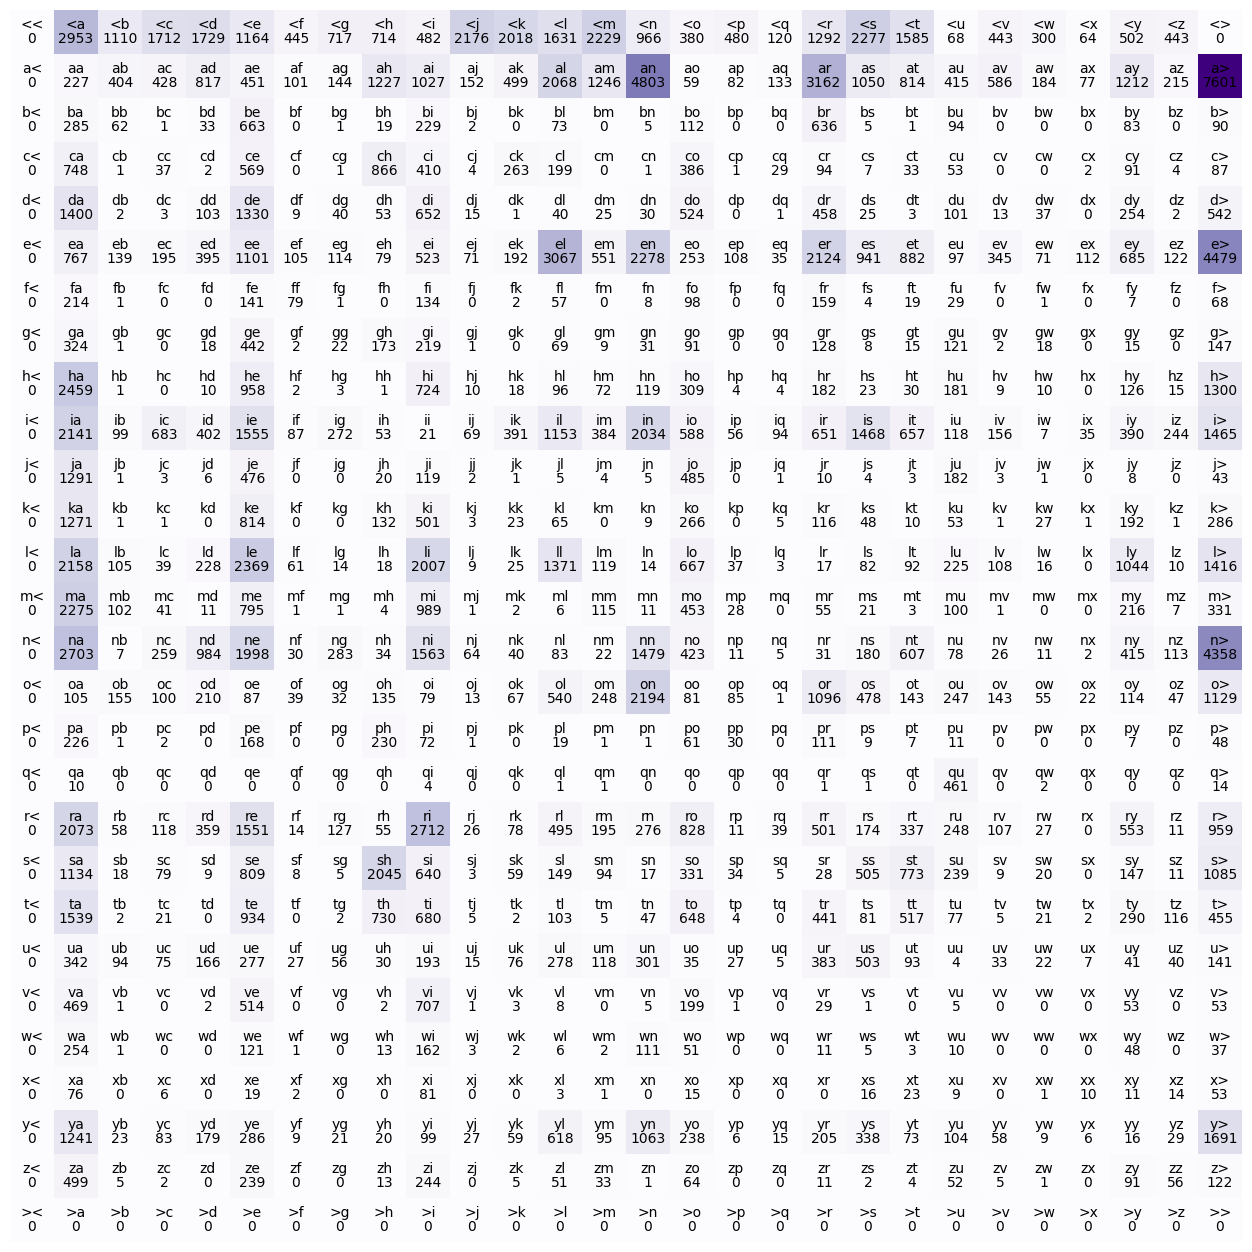

In [72]:
# Plot heatmap
plt.figure(figsize=(16,16))
plt.imshow(T, cmap='Purples')
for i in range(28):
    for j in range(28):
        bigram = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color='black')
        plt.text(j, i, T[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');

Some observations from this:
1. The first column `T[:, 0]` and last row `T[27,:]` all contain 0s for counts. This is because they indicate bigrams that end with the start symbol and start with the ending character respectively, which aren't valid bigrams - this is something we can improve on by rethinking our bigram representation.
2. Some entries of the matrix have 0 counts. These correspond to bigrams that don't appear within our training data such as `qb` or `vt`. This because English names with these bigrams are unlikely. However to generate new names we may want these bigrams to be possible. A common trick to allow these to exist is to initialize the matrix with all 1s first - this will result in a very small, but non-zero probability for these bigrams without changing the probability of commom bigrams by much.

To proceed we'll combine our special starting and stopping characters into one character `.` (more on this later.) 
This will reduce our matrix to 27x27. 
We'll also initialize our matrix with all ones to allow all possible bigrams to occur. 

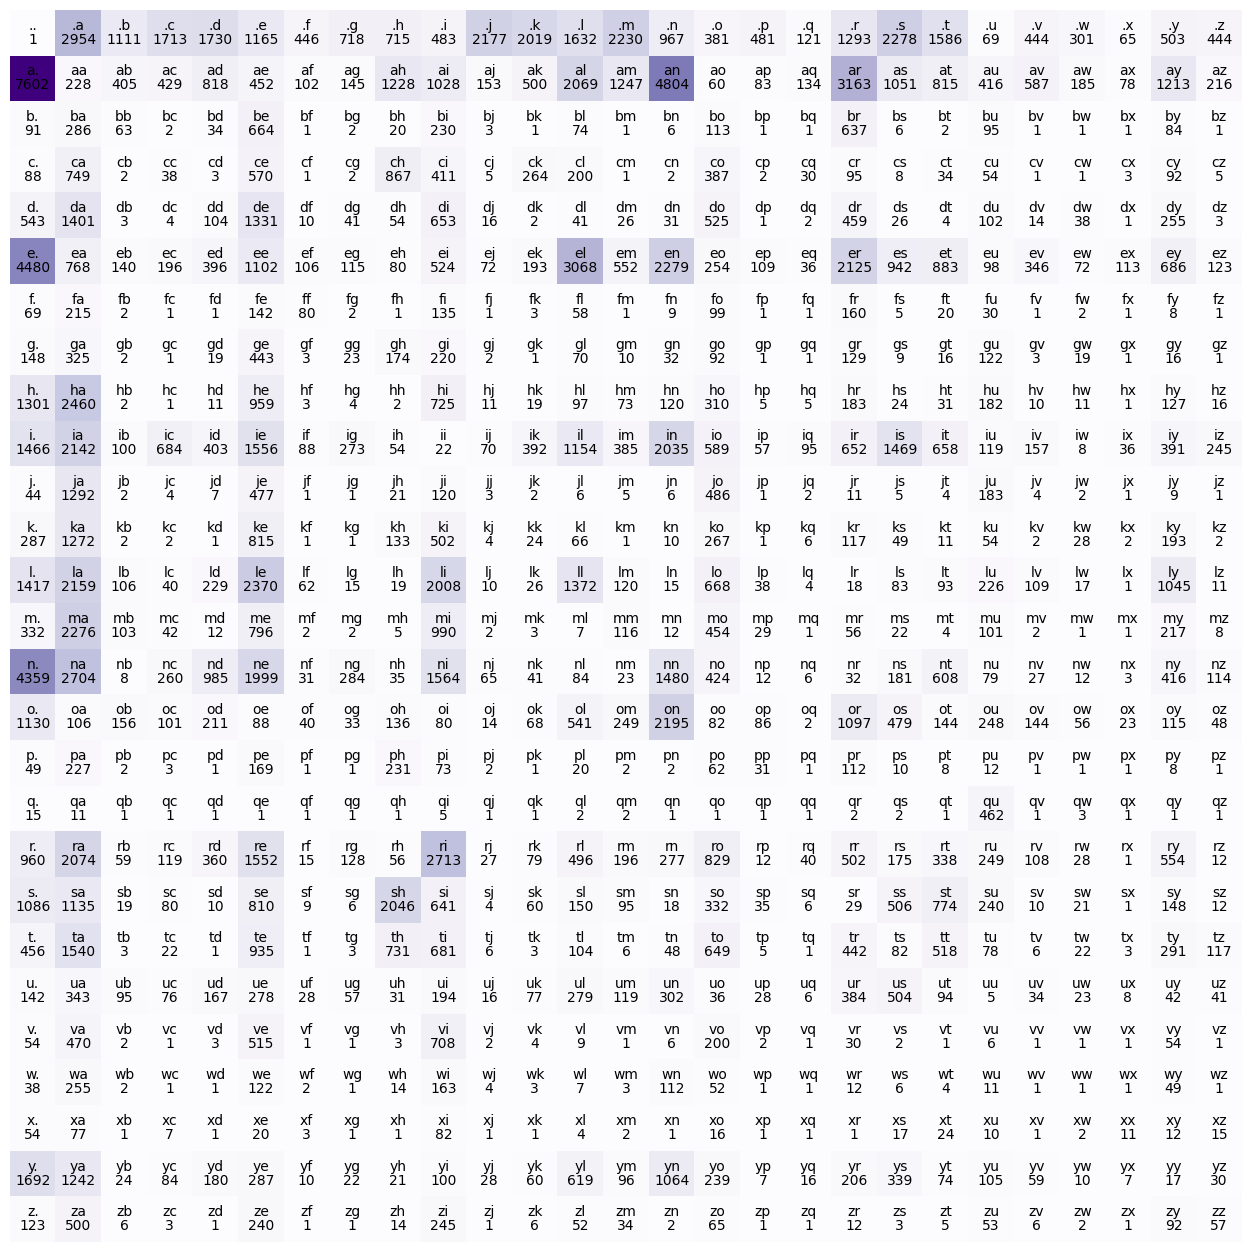

In [73]:
# Recreate steps above:

T = torch.ones((27,27), dtype=torch.int32)

# string of all 26 characters sorted a to z. Works as all characters appear in training set.
chars = sorted(list(set(''.join(train_set))))
# mapping of characters to index.
char_to_idx['.'] = 0
for i,c in enumerate(chars):
    char_to_idx[c] = i+1
# create reverse mapping for use when plotting. 
idx_to_char = {i:c for c,i in char_to_idx.items()}

# Populate tensor with counts
for w in train_set:
    chars = ['.']+list(w)+['.']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        T[idx0, idx1] += 1
        
# Plot heatmap
plt.figure(figsize=(16,16))
plt.imshow(T, cmap='Purples')
for i in range(27):
    for j in range(27):
        bigram = idx_to_char[i] + idx_to_char[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color='black')
        plt.text(j, i, T[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');

Now we can interpret the first row of the matrix to indicate bigrams from strings that start with a character and the first column bigrams from strings that end with that character. 
For example, the name `justin` would contain the bigrams `.j` and `n.` as the first and last bigrams respectively.

## Sampling from our model - creating new names!

In the matrix above we have the occurrence counts of all possible bigrams from our training dataset.
Comparing these counts from one bigram against another represents how often we would expect to see one bigram vs. another. 
For example consider the two bigrams with counts `.b -> 1111` and `.m -> 2230` - these indicates that we would expect to see bigram `.m` twice as often as `.b`.
Note: what the matrix is really doing is **modeling** the information (probability of different bigrams) present in our training data.
A different training set would provide different counts and thus a different model. 

What we would really like is to interpret these counts as a probability distribution.
To convert these to a distribution we can simply sum up the total counts then divide each entry by this sum:

In [74]:
# convert integer to float
p = T[0].float()
p = p / p.sum()
# set print options
torch.set_printoptions(sci_mode=False)
print("Sum should be 1:", p.sum())
p

Sum should be 1: tensor(1.)


tensor([    0.0000,     0.1054,     0.0396,     0.0611,     0.0617,     0.0416,
            0.0159,     0.0256,     0.0255,     0.0172,     0.0777,     0.0720,
            0.0582,     0.0796,     0.0345,     0.0136,     0.0172,     0.0043,
            0.0461,     0.0813,     0.0566,     0.0025,     0.0158,     0.0107,
            0.0023,     0.0179,     0.0158])

But how do we generate new names? 
The way to think of each row is as a conditional probability distribution. 
Each row represents a bigram `XY` where the value within gives the probability that character `Y` given that character `X` precedes it. 

By randomly sampling a character according to these distributions we can generate a new name. 
We start with the first row - bigrams of the form `.X` - and choose `X=x` according to the distribution. 
We then go to the row corresponding to bigrams of the form `xY` and choose `Y=y` according to the distribution, and continue. 
Eventually we will choose bigram, `xy` such that `y=.` our terminating character. At this points we stop the name generation and have our new name. 

Let's now see how we can implement this.

In [75]:
# First, covert occurrence matrix to matrix of probabilities.
# Create copy
P = T.float()
# Normalize each row to probability distribution summing across row.
P /= P.sum(1, keepdims=True)

In [76]:
# Use a generator to sample character from a row.
g = torch.Generator().manual_seed(892347120)
# Sample 20 names from the model.
for i in range(20):
    out = []
    # start in first row
    idx = 0
    while True:
        # Sample a character from the row. What is returned is the index of the character within a tensor. 
        sample = torch.multinomial(P[idx], num_samples=1, replacement=True, generator=g)
        idx = sample.item()
        if idx == 0:
            # idx value 0 (first column) is the stoping character .
            break
        out.append(idx_to_char[idx])
    name = ''.join(out)
    print(f"Name: '{name}'. Name is in training set? {name in train_set}")

Name: 'lli'. Name is in training set? False
Name: 'ialindarie'. Name is in training set? False
Name: 'lyamio'. Name is in training set? False
Name: 'ripa'. Name is in training set? False
Name: 'domanymy'. Name is in training set? False
Name: 'erin'. Name is in training set? True
Name: 'tietorlerle'. Name is in training set? False
Name: 'dawiki'. Name is in training set? False
Name: 'nirecondela'. Name is in training set? False
Name: 'imean'. Name is in training set? False
Name: 'mmiseryo'. Name is in training set? False
Name: 'shrvalphala'. Name is in training set? False
Name: 'clhatesoleelaynosi'. Name is in training set? False
Name: 'kka'. Name is in training set? False
Name: 'yqniavoma'. Name is in training set? False
Name: 'ialeshyamietena'. Name is in training set? False
Name: 'e'. Name is in training set? False
Name: 'lesio'. Name is in training set? False
Name: 'gay'. Name is in training set? True
Name: 'sheiruiaeli'. Name is in training set? False


### Investigating the results

Above we've generated 20 names. We've also checked if they are present within our training set. 
Some are actual names such as "gay" and "erin", but these exist in our training set. 
Other names seem plausible such as "ripa", "dawiki", and "lesio". However most of the names don't *sound* like real names like "tietorlerle".
Continuing to generate more names will reveal similar findings. 

So what's wrong with our model? Well there are a few things that could explain these results:
- Our model does not have enough training data. Our training data consists of 28,000 English names from the US. It is possible that this set of names does not sufficiently represent the population of all English names. 
- Bigrams do not capture enough context. Bigrams only capture a *window size* of 2 which is not enough to capture context for longer names. For example, subsequences such as "son" or "ack" are not captured directly.

We could generalize our model to be an "n-gram: model (bigram is 2-gram) for `n=3,4,5,...`.
This approach will allow us capture a larger window of context. However a downside of this approach is scalability.
For a 3-gram model, we would need a 27x27x27 size matrix.
For larger alphabets (such as both capitalized and uncapitalized letters, digits, special characters, etc.) we would need a matrix of size $|A|^n$ where |A| is the size of the alphabet.

Another observation is a meta one - we can view the outputs of our model and say whether not they look like a real name, 
but we don't have an unbias way to determine if our model is performing well. 
We generated 20 random names above - if we generated more names would we deems these names as being more realistic or less than what we saw above?
One approach would be to compare our model against a model that assigns a uniform probability to each bigram. 


In [77]:
# Create a matrix where each bigram as a uniform probability. 
O = torch.ones((27,27), dtype=torch.int32)
U = O.float()
# Normalize each row to probability distribution summing across row.
U /= torch.ones((27,27)).sum(1, keepdims=True)
# Use a generator to sample character from a row.
g = torch.Generator().manual_seed(892347120)
# Sample 20 names from the model.
for i in range(20):
    out = []
    # start in first row
    idx = 0
    while True:
        # Sample a character from the row. What is returned is the index of the character within a tensor. 
        sample = torch.multinomial(U[idx], num_samples=1, replacement=True, generator=g)
        idx = sample.item()
        if idx == 0:
            # idx value 0 (first column) is the stoping character .
            break
        out.append(idx_to_char[idx])
    name = ''.join(out)
    print(f"Name: '{name}'. Name is in training set? {name in train_set}")

Name: 'ltgiiwlbndmrpecohxmiqdrjpjenymdtxwy'. Name is in training set? False
Name: 'uqnndtukbkqlowpez'. Name is in training set? False
Name: 'kwmisgnhrpcmzlflmkimqam'. Name is in training set? False
Name: 'mmtszwyo'. Name is in training set? False
Name: 'qgbvrlpkdlagclhttufzfnfojxvvbzmkke'. Name is in training set? False
Name: 'yqniivbmjqiyeuxhpimgkvjnaiqdbzziopgayjubfiruixeknzckxzgzxd'. Name is in training set? False
Name: 'eqssiwsoypvrgztlcywltehewjbjldhbixm'. Name is in training set? False
Name: 'wcyovxsuincipklyuwzthptgmypffbjpkhfbjnrdfdzi'. Name is in training set? False
Name: 'is'. Name is in training set? False
Name: 'mthzejthebwkvmwjboxojfypxoqncdgsznclkkoqhpitnldpchgcd'. Name is in training set? False
Name: 'lvrcbvbvlbnebixnktlzaakuepzzuanbgbytztqtqqesyfwybtkosjuerxmeu'. Name is in training set? False
Name: 'zdwreyqaedqmxawqpspdduclgmejbjjlxlkfwvksx'. Name is in training set? False
Name: 'ykzlcrhs'. Name is in training set? False
Name: 'bupjomnkanlhvxakwxvhuvnx'. Name is in tra

In comparison, our model seems to out perform the uniform one.
However we still face the bias issue: if we have sample different names from the two models, would our model have performed worse than the uniform?
Ideally, we'd like a numeric way to define just how good our model is.
Such a definition will be both useful to compare our model against another, or to iteratively improve our model by comparing previous model iterations against the latest one. 

## Maximum Likelihood and Negative Log-Likelihood

Let's do a quick recap:
- We created a model (our two dimensional matrix) that assigns probabilities to our bigrams.
- These probabilities came from occurrence counts of bigrams within our training dataset.
- Using a different dataset would provide different probabilities within our model.
- We observed the probabilities of some words and the bigrams within them: recall the name "erin" was within our dataset. Let's see what probabilities our model assigned to it vs. "xbyajv" which wasn't in our dataset:

In [78]:
for w in ["erin", "xbyajv"]:
    chars = ['.']+list(w)+['.']
    # use zip function to make every bigram in chars
    print(w)
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        prob = P[idx0, idx1]
        print(f"{c1}{c2}:{prob:.4f}")
    

erin
.e:0.0416
er:0.1070
ri:0.2269
in:0.1330
n.:0.2753
xbyajv
.x:0.0023
xb:0.0027
by:0.0347
ya:0.1871
aj:0.0052
jv:0.0015
v.:0.0260


So far, we've been asking *what is the probability of bigrams, given our model?* (written $P(X | \theta) )$ where $\theta$ is the probabilities of our model.
We could combine both our bigram (data) and model into a single probability density function (pdf) $p(x, \theta)$ which would tell us the probability of our bigrams and model.

Conversely, we could ask *what is the probability of our model, give our data?* That is, what is the **likelihood** of our model, given the data? This likelihood is defined as the pdf above:
$$
L(\theta | X) = p(X=x, \theta)
$$
Note that likelihood is a function of our model as we have a single, fixed training dataset. 

We now make a critical assumptuion: we assume that our data is both independent and identically distributed (IID.) 
This assumption is needed to simplify our joint distribution: for two IID random variables $A,B$ with joint distribution $P_{A,B}(a,b)$ we can split it into the product of two marginal distributions:
$$
P_{A,B}(a,b) = P_A(a)P_B(b)
$$
For example, in our model this would imply that probability of ".e" and "by" is the product of probabilities for each separately (this is assumed for all bigrams.) So likelihood woul then be
$$
L(\theta | X) = \Pi P(X=x, \theta)
$$

So we've defined this value - likelihood - as a product of our model's probabilities, but what does it give us? 
Recall we arrived out our model parameters by using occurrence counts then normalizing these to probabilities.
This is a natural way to generate these probabilities but we've could've done so in another way such as using the uniform distribution. 
Yet, as we'll see below, our bigram model will have a larger likelihood than the uniform model, and this is the key observation: models that fit our dataset will have a larger (better) likelihood than those that do not.

With this in mind, we now have a goal: find a model that maximizes the likelihood that it fits our dataset. 

### Swapping the likelihood for the negative log likelihood

As defined above to compute the probability of our model we'll need to take the product of all the bigram probabilities.
However, since probabilities are between 0 and 1, this product will approach zero very quickly and would be unstable for computers to calculate with precision. 

To work around this we use the following facts:
1. $log(ab) = log(a) + log(b)$
2. The log function is a monotonically increasing function (will be used when we optimize our model)
3. Maximizing negative values is equivalent to minimizing positive values.

By considering the log likelihood (apply the log function to both sides) we now sum the log-probabilities. 
Since the log of values between 0 and 1 are negative, the **negative log-likelihood (NLL)** is a positive value. 
If we aim to maximize the likelihood, we can minimize the negative log likelihood.

Finally we'll normalize this value by averaging it over the number of model parameters we have to evaluate:

$$
NLL = \frac{-1}{n} \sum_{i}^{n} log(p(\theta_i, X=x))
$$

Let's now compute the NLL for our two models:

In [79]:
P_LL = 0.0
U_LL = 0.0
n = 0
for w in train_set:
    chars = ['.']+list(w)+['.']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        prob = P[idx0, idx1]
        P_LL += torch.log(prob)
        prob = U[idx0, idx1]
        U_LL += torch.log(prob)
        n+=1

P_NLL = -1 * P_LL
U_NLL = -1 * U_LL


In [80]:
print(f"Bigram model: avg NLL: {P_NLL/n:.4f}")
print(f"Uniform model: avg NLL: {U_NLL/n:.4f}")

Bigram model: avg NLL: 2.4471
Uniform model: avg NLL: 3.2942


As expected, we see that our bigram model has a lower average NLL that our uniform model. Finally, let's see how the models do when using words from our validation set:

In [81]:
valid_set
P_LL = 0.0
U_LL = 0.0
n = 0
for w in valid_set:
    chars = ['.']+list(w)+['.']
    # use zip function to make every bigram in chars
    for c1,c2 in zip(chars, chars[1:]):
        idx0 = char_to_idx[c1]
        idx1 = char_to_idx[c2]
        prob = P[idx0, idx1]
        P_LL += torch.log(prob)
        prob = U[idx0, idx1]
        U_LL += torch.log(prob)
        n+=1

P_NLL = -1 * P_LL
U_NLL = -1 * U_LL

In [82]:
print(f"Bigram model: avg NLL: {P_NLL/n:.4f}")
print(f"Uniform model: avg NLL: {U_NLL/n:.4f}")

Bigram model: avg NLL: 2.4558
Uniform model: avg NLL: 3.2958


## Summary

In this notebook we implemented a bigram model for generating English first names. 
Using a dataset of first names, we computed the probabilities all possible bigram by counting the occurrences of each within the dataset. 

We reviewed the performance and found it did okay on generating news, but could be improved. 
We also compared it against the uniform model - a model that assigns an equal probability to all bigrams and found our model did better. 
These observations prompted questions on what would be a systematic way to compare our model against other models which lead us to defining 
maximum likelihood and negative log likelihood.

In the next notebook we re-implement our bigram model but instead of finding probabilities based on occurrence counts, we'll see how we can learn these probabilities by using an iterative approach that follows attempts to decrease the NLL of our model at each iteration, casting the problem into optimizing a neural network. 

